<a href="https://colab.research.google.com/github/jcumbicosr/processamento-linguagem-natural/blob/main/Ajuste_fino_usando_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercício: Modelo de Linguagem com auto-atenção e máscaras causais com ajuste fino usando LoRA

O objetivo deste trabalho é treinar um modelo de linguagem com auto-atenção e máscara causal, utilizando 70% dos dados para o treinamento (exercicio anterior). Em seguida, são adicionadas as matrizes A e B nas camadas lineares e nos embeddings para realizar o ajuste fino por meio da técnica LoRA, onde apenas os pesos das matrizes A e B são atualizados, usando 20% dos dados.

In [ ]:
!pip install torchinfo -q

In [ ]:
import os
import re
import torch
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.nn import Embedding
from collections import Counter
from torchinfo import summary

## Dados

Vamos usar o mesmo dataset do Machado de Assis.



In [ ]:
!git clone https://github.com/ethelbeluzzi/projetomachado

Cloning into 'projetomachado'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.21 MiB | 3.60 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

min_words = 6 # Minimum number of words per line
cleaned_lines = []
line_lens = []
total_words = 0
# Abrir arquito textual e ler os dados originais
with open(DATA_PATH, "r") as data_file:
    for line in data_file:
        # Limpar linhas, removendo \n, espaços antes e depois
        line = line.strip().lower()
        # Remove punctuation marks, except , and.
        line = re.sub(r'[^\w\s,.]', '', line)
        # Apagar linhas menor que min_words
        num_words = len(line.split())
        if num_words < min_words:
            continue
        # Contador de palavras
        total_words += num_words
        cleaned_lines.append(line)
        line_lens.append(len(line))
print(f'Total de linhas: {len(cleaned_lines)}')
print(f'Total de palavras: {total_words}')
print(f'Total de caracteres: {sum(line_lens)}')

Total de linhas: 233809
Total de palavras: 3086352
Total de caracteres: 17226274


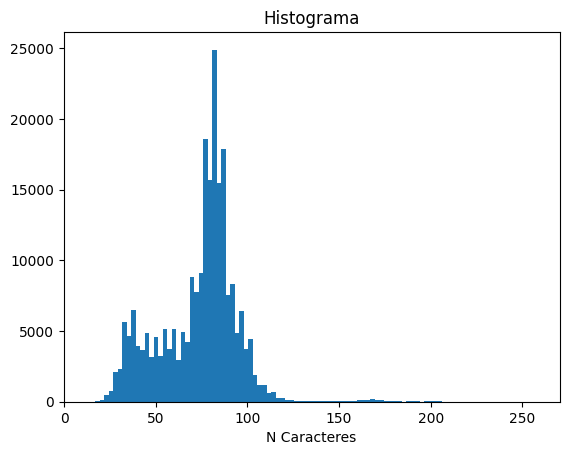

In [ ]:
#@title Plot histogram

plt.title("Histograma")
plt.hist(line_lens, bins=100)
plt.xlabel("N Caracteres")
plt.show()

## Building a tokenizer

In [ ]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

my_tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

my_tokenizer.normalizer = normalizers.Sequence(
    #[normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
    [normalizers.NFD(), normalizers.Lowercase()]
)
print("Normalizer: ", my_tokenizer.normalizer.normalize_str("Olá, tudo bem?"))

my_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
print("Pre-tokenizer: ", my_tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer."))


Normalizer:  olá, tudo bem?
Pre-tokenizer:  [('Let', (0, 3)), ("'", (3, 4)), ('s', (4, 5)), ('test', (6, 10)), ('my', (11, 13)), ('pre', (14, 17)), ('-', (17, 18)), ('tokenizer', (18, 27)), ('.', (27, 28))]


### Train tokenizer

In [ ]:
# OPTION 1
# my_tokenizer.model = models.WordPiece(unk_token="[UNK]")
# my_tokenizer.train(cleaned_lines[:100], trainer=trainer)

# OPTION 2
def get_training_corpus(text):
    for start_idx in range(0, len(text), 1000):
        yield text[start_idx : start_idx + 1000]

special_tokens = ["[UNK]", "[PAD]", "[SOS]", "[EOS]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=5000, special_tokens=special_tokens)

#my_tokenizer.train_from_iterator(get_training_corpus(cleaned_lines[:100]), trainer=trainer)
my_tokenizer.train_from_iterator(get_training_corpus(cleaned_lines), trainer=trainer)

In [ ]:
cls_token_id = my_tokenizer.token_to_id("[SOS]")
sep_token_id = my_tokenizer.token_to_id("[EOS]")
print(f'ID for [SOS]:{cls_token_id}\nID for [EOS]:{sep_token_id}')

my_tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[SOS]:0 $A:0 [EOS]:0",
    pair=f"[SOS]:0 $A:0 [EOS]:0 $B:1 [EOS]:1",
    special_tokens=[("[SOS]", cls_token_id), ("[EOS]", sep_token_id)],
)

ID for [SOS]:2
ID for [EOS]:3


In [ ]:
encoding = my_tokenizer.encode("não foi igualmente bonito nem sumário.")
print(encoding.tokens)

encoding = my_tokenizer.encode("não foi igualmente bonito nem sumário.", "estêvão meteu a mão nos cabelos")
print(encoding.tokens)
print(encoding.type_ids)

['[SOS]', 'não', 'foi', 'igualmente', 'bonito', 'nem', 'suma', '##́rio', '.', '[EOS]']
['[SOS]', 'não', 'foi', 'igualmente', 'bonito', 'nem', 'suma', '##́rio', '.', '[EOS]', 'estêvão', 'meteu', 'a', 'mão', 'nos', 'cabelos', '[EOS]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
my_tokenizer.decoder = decoders.WordPiece(prefix="##")
my_tokenizer.decode(encoding.ids)

'não foi igualmente bonito nem sumário. estêvão meteu a mão nos cabelos'

### Save and load tokenizer

In [ ]:
my_tokenizer.save("my_tokenizer.json")

In [ ]:
from transformers import PreTrainedTokenizerFast

my_tokenizer = PreTrainedTokenizerFast(
    # tokenizer_object=tokenizer,
    tokenizer_file="my_tokenizer.json", # You can load from the tokenizer file, alternatively
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[SOS]",
    sep_token="[EOS]",
    mask_token="[MASK]",
    clean_up_tokenization_spaces=True
)

## Classe do dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

context_size = 9 # 5 palavras de entrada. O target é a próxima palavra

"""TODO: Preparar o dataset"""
class MachadoDataset(Dataset):
    def __init__(self, text, vocab, context_size=5, debug=False):
        """
        Dataset class for processing text data for training a language model.
        Args:
            text (list): List of strings representing the text data.
            vocab (Vocabulary): Vocabulary object containing the mapping of tokens to indices.
            context_size (int, optional): Size of the context window. Defaults to 5.
            debug (bool, optional): Whether to print debug information. Defaults to False.
        """
        # Check if text is a list with two or more lines
        if not isinstance(text, list) or len(text) < 2:
            raise ValueError("The 'text' variable must be a list with at least two lines of text.")

        self.vocab = vocab
        self.context_size = context_size
        self.debug = debug

        self.source = []
        self.target = []

        UNK_TOKEN = vocab.convert_tokens_to_ids("[UNK]") # Use tokenizer to get UNK token ID
        EOS_TOKEN = vocab.convert_tokens_to_ids("[EOS]") # Use tokenizer to get EOS token ID

        # Loop through each line in the text
        for line in text:
            if self.debug:
                print(f'\n\nRaw text: {line}')
            # Tokenizer the phrase and add special tokens: SOS, EOS
            #tokens = [SOS_TOKEN] + encode_sentence(line, vocab) + [EOS_TOKEN]
            tokens = vocab(line).input_ids
            if self.debug:
                print(f'Tokens  : {tokens}')

            # Calculate padding if sequence length is not a multiple of context_size
            # padding_length = (context_size - len(tokens) % context_size) % context_size
            # tokens.extend([PAD_TOKEN] * padding_length)

            # Truncate tokens if sequence length is not a multiple of context_size
            max_len = ((len(tokens) -1) // context_size) * context_size
            tokens = tokens[:max_len]
            tokens.extend([EOS_TOKEN])

            if self.debug:
                print(f'Padding : {tokens}')

            # Loop through the sequence with a window of size context_size
            for i in range(len(tokens) - context_size ):
                # Input is a slice of size context_size
                input_seq = tokens[i:i + context_size]
                # Target is a slice of size context_size, shifted right by one position
                target_seq = tokens[i + 1:i + context_size + 1]

                # Replace [UNK] by [PAD] token in target sequence
                target_seq = [0 if token == UNK_TOKEN else token for token in target_seq]

                #if UNK_TOKEN in target_seq:
                #    continue
                #if UNK_TOKEN in input_seq:
                #    continue

                self.source.append(input_seq)
                self.target.append(target_seq)

                if self.debug:
                    # Right-align each number with 5 spaces
                    row1_str = " ".join(f"{num:>5}" for num in input_seq)
                    row2_str = " ".join(f"{num:>5}" for num in target_seq)
                    print(f"source: [{row1_str}]  |  target: [{row2_str}]")

    def __len__(self):
        return len(self.source)

    def __getitem__(self, idx):
        return torch.tensor(self.source[idx]), torch.tensor(self.target[idx])

In [ ]:
#@title Check Dataset implementation

#my_dataset = MachadoDataset(cleaned_lines[6:8], vocab, context_size, debug=True)
my_dataset = MachadoDataset(cleaned_lines[6:8], my_tokenizer, context_size, debug=True)
sample = my_dataset[0]
print(f'Length of Dataset: {len(my_dataset)}')
print('==> Sample <==')
print(f'Source: {sample[0]}')
print(f'Target: {sample[1]}')



Raw text: estêvão meteu a mão nos cabelos com um gesto de angústia luís alves sacudiu a cabeça
Tokens  : [2, 2443, 2823, 18, 651, 305, 2193, 136, 126, 1000, 103, 250, 161, 1977, 1071, 2728, 3105, 829, 18, 788, 3]
Padding : [2, 2443, 2823, 18, 651, 305, 2193, 136, 126, 1000, 103, 250, 161, 1977, 1071, 2728, 3105, 829, 3]
source: [    2  2443  2823    18   651   305  2193   136   126]  |  target: [ 2443  2823    18   651   305  2193   136   126  1000]
source: [ 2443  2823    18   651   305  2193   136   126  1000]  |  target: [ 2823    18   651   305  2193   136   126  1000   103]
source: [ 2823    18   651   305  2193   136   126  1000   103]  |  target: [   18   651   305  2193   136   126  1000   103   250]
source: [   18   651   305  2193   136   126  1000   103   250]  |  target: [  651   305  2193   136   126  1000   103   250   161]
source: [  651   305  2193   136   126  1000   103   250   161]  |  target: [  305  2193   136   126  1000   103   250   161  1977]
source: [  305  

In [ ]:
#@title Create the complete dataset

#my_dataset = MachadoDataset(cleaned_lines, vocab, context_size)
my_dataset = MachadoDataset(cleaned_lines, my_tokenizer, context_size)
print(f'Length of Dataset: {len(my_dataset)}')
print('==> Samples <==')
for idx in range(3):
    sample = my_dataset[idx]
    print(f'Source: {sample[0]}  | Target: {sample[1]}')

Length of Dataset: 1976424
==> Samples <==
Source: tensor([   2, 1710,  109,  711, 1361,  143, 1536,    5, 2443])  | Target: tensor([1710,  109,  711, 1361,  143, 1536,    5, 2443,    3])
Source: tensor([   2, 1370,  133,    6,  537,  130, 1982,  185, 1173])  | Target: tensor([1370,  133,    6,  537,  130, 1982,  185, 1173, 4686])
Source: tensor([1370,  133,    6,  537,  130, 1982,  185, 1173, 4686])  | Target: tensor([ 133,    6,  537,  130, 1982,  185, 1173, 4686,  130])


In [ ]:
#@title Split Dataset

"""TODO: divida o dataset em validação/treino com um proporção de 20/80 %. OBS, use random_state=18"""

#train_size = int(0.8 * len(my_dataset))
#valid_size = len(my_dataset) - train_size
#train_dataset, valid_dataset = torch.utils.data.random_split(my_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(18))

train_size = int(0.7 * len(my_dataset))
val_size = int(0.2 * len(my_dataset))
test_size = len(my_dataset) - train_size - val_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(18))


print(f'Train size: {len(train_dataset)}')
print(f'Valid size: {len(valid_dataset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 1383496
Valid size: 395284
Test size: 197644


In [ ]:
#@title Create DataLoader

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

sample = next(iter(train_loader))
print(f'Shape of source: {sample[0].shape}')
print(f'Shape of target: {sample[1].shape}')

Shape of source: torch.Size([128, 9])
Shape of target: torch.Size([128, 9])


## Model

In [ ]:
#@title Class definitions
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Multi-Head Attention module.
        Args:
            d_model (int): The dimension of the model.
            num_heads (int): The number of attention heads.
        B = Batch size
        S = Sequence length
        H = Number of heads
        D = Attention head dimension
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.Wv = nn.Linear(d_model, d_model, bias=False)  # the Value part
        self.Wk = nn.Linear(d_model, d_model, bias=False)  # the Key part
        self.Wq = nn.Linear(d_model, d_model, bias=False)  # the Query part
        self.Wo = nn.Linear(d_model, d_model, bias=False)  # the output layer

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        x = x.view(batch_size, seq_length, self.num_heads, self.d_k)
        return x.transpose(1, 2)  # (B, H, S, D)

    def scaled_dot_product_attention(self, Q, K, V, attention_mask=None, key_padding_mask=None):
        tgt_len, src_len = Q.size(-2), K.size(-2)
        # (B, H, S, D) * (B, H, D, S) = (B, H, S, S)
        logits = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Attention mask here
        if attention_mask is not None:
            if attention_mask.dim() == 2:
                assert attention_mask.size() == (tgt_len, src_len)
                attention_mask = attention_mask.unsqueeze(0)
                logits = logits + attention_mask
            else:
                raise ValueError(
                    f"Attention mask size {attention_mask.size()}")

        # Key mask here
        # TODO

        attention = torch.softmax(logits, dim=-1)
        # (B, H, S, S) * (B, H, S, D) =  (B, H, S, D)
        output = torch.matmul(attention, V)

        return output, attention

    def combine_heads(self, x):
        batch_size, num_heads, seq_length, d_k = x.size()
        # return: (B, S, d_model)
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, attention_mask=None, key_padding_mask=None):
        # Q, K, V: (batch_size, seq_length, d_model)
        V = self.Wv(V)
        K = self.Wk(K)
        Q = self.Wq(Q)

        V = self.split_heads(V)
        K = self.split_heads(K)
        Q = self.split_heads(Q)

        attn_output, attn_weights = self.scaled_dot_product_attention(
            Q, K, V, attention_mask, key_padding_mask)
        grouped = self.combine_heads(attn_output)
        output = self.Wo(grouped)

        return output, attn_weights

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_size, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Point-wise feed forward network
        self.linear1 = nn.Linear(d_model, ff_hidden_size)
        self.linear2 = nn.Linear(ff_hidden_size, d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        self.attention_weights = attn_weights

        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Position-wise feed-forward layer
        ff_output = self.linear2(F.relu(self.linear1(x)))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return x


class LanguageModel(torch.nn.Module):
    """TODO: implementar o modelo de linguagem"""
    def __init__(self, vocab_size, embedding_dim, seq_len, hidden_size, num_layers, num_heads, dropout=0.3):
        super(LanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.seq_len = seq_len

        self.embedding = Embedding(vocab_size, embedding_dim)
        #self.positional = PositionalEncoding(embedding_dim, seq_len)
        self.positional = Embedding(seq_len, embedding_dim)

        self.decoder_layers = nn.ModuleList([
            DecoderLayer(embedding_dim, num_heads, hidden_size, dropout)
            for _ in range(num_layers)
        ])

        # Specific task
        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        #x = self.positional(x)
        p = self.positional(torch.arange(x.size(1), device=x.device))
        x = x + p

        for layer in self.decoder_layers:
            x = layer(x, mask)

        # Final MLP model
        x = F.relu(self.fc1(x))  # Use [EOS] token's representation
        x = self.fc2(self.dropout(x))
        return x

In [ ]:
#@title Create model

# Define hyperparameters
#vocab_size = len(vocab)+ 1   # Size of the vocabulary
vocab_size = my_tokenizer.vocab_size  # Size of the vocabulary
d_model = 64                 # Dimension of model
seq_len = sample[0].size(-1) # Sequence length
hidden_size = 512            # Number of neurons in the hidden layer
num_layers = 2               # Number of layers
num_heads = 4                # Number of heads in multi-head attention

# Model instation
model = LanguageModel(vocab_size, d_model, seq_len, hidden_size, num_layers, num_heads)

summary(model,input_data=sample[0], depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
LanguageModel                            [128, 9, 5000]            --
├─Embedding: 1-1                         [128, 9, 64]              320,000
├─Embedding: 1-2                         [9, 64]                   576
├─ModuleList: 1-3                        --                        --
│    └─DecoderLayer: 2-1                 [128, 9, 64]              --
│    │    └─MultiHeadAttention: 3-1      [128, 9, 64]              16,384
│    │    └─Dropout: 3-2                 [128, 9, 64]              --
│    │    └─LayerNorm: 3-3               [128, 9, 64]              128
│    │    └─Linear: 3-4                  [128, 9, 512]             33,280
│    │    └─Linear: 3-5                  [128, 9, 64]              32,832
│    │    └─Dropout: 3-6                 [128, 9, 64]              --
│    │    └─LayerNorm: 3-7               [128, 9, 64]              128
│    └─DecoderLayer: 2-2                 [128, 9, 64]            

## Training

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#@title Functions

def plot_learning_curves(history):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['train_loss'], label='train')
  plt.plot(history['eval_loss'], label='eval')
  plt.legend()
  plt.title('Loss')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.plot(history['train_acc'], label='train')
  plt.plot(history['eval_acc'], label='eval')
  plt.legend()
  plt.title('Accuracy')
  plt.xlabel('epoch')
  plt.show()

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    test_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        logits = model(inputs)
        # Calculate loss
        loss = criterion(logits.contiguous().view(-1, model.vocab_size),
                             targets.contiguous().view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=-1)
        accuracy = (preds == targets).float().mean()
        test_acc += accuracy.item()

    return total_loss / len(train_loader), (test_acc / len(train_loader)) * 100

def valid_epoch(model, valid_loader, criterion, device):
    ## evaluation
    val_acc = 0
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)

            # Calculate loss
            loss = criterion(logits.contiguous().view(-1, model.vocab_size),
                             targets.contiguous().view(-1))
            val_loss += loss.item()

            # Calculate acc
            preds = logits.argmax(dim=-1)
            accuracy = (preds == targets).float().mean()
            val_acc += accuracy.item()

    return val_loss / len(valid_loader), (val_acc / len(valid_loader)) * 100

def train(model, train_loader, valid_loader, criterion, optimizer, epochs, device):
    # Save history to dictionnary
    history = {
        'train_loss': [],
        'eval_loss': [],
        'train_acc': [],
        'eval_acc': []
    }

    # Move the model to the appropriate device (GPU or CPU)
    model.to(device)

    # Initial evaluation
    ini_loss, ini_acc = valid_epoch(model, valid_loader, criterion, device)
    perplexity = torch.exp(torch.tensor(ini_loss))
    print(f'[Initial] Test loss:{ini_loss:.4f}, Test acc:{ini_acc:.2f}%, Perplexity:{perplexity:.2f}')

    # Training loop
    for epoch in range(epochs):
        start_time_epoch = time.time()  # Start time of the epoch

        # train model
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # evaluate model
        val_loss, val_acc = valid_epoch(model, valid_loader, criterion, device)

        end_time = time.time()  # End time of the epoch
        epoch_duration = end_time - start_time_epoch  # Duration of epoch

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['eval_loss'].append(val_loss)
        history['eval_acc'].append(val_acc)

        perplexity = torch.exp(torch.tensor(val_loss))
        print(f'Epoch [{epoch+1}/{epochs}], Train loss:{train_loss:.4f}, Train acc:{train_acc:.2f}%, '
            f'Test loss:{val_loss:.4f}, Test acc: {val_acc:.2f}%, '
            f'Perplexity:{perplexity:.2f}, Elapsed Time: {epoch_duration:.2f} sec')

    return history

In [ ]:
#@title Run training
import time

epochs = 5
lr = 1e-4; """TODO, experimente!"""
#criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN); """TODO CrossEntropy"""
criterion = nn.CrossEntropyLoss(ignore_index=my_tokenizer.convert_tokens_to_ids("[PAD]")); """TODO CrossEntropy"""

# Model instantiation
model = LanguageModel(vocab_size, d_model, seq_len, hidden_size, num_layers, num_heads)

#optimizer = torch.optim.Adam(model.parameters(), lr=lr); """TODO: AdamW ou outro, experimente!"""
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

history = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)
#history = train(model, train_loader, valid_loader, criterion, optimizer, epochs, device)

[Initial] Test loss:8.5048, Test acc:0.05%, Perplexity:4938.46
Epoch [1/5], Train loss:1.4665, Train acc:78.03%, Test loss:0.6740, Test acc: 90.19%, Perplexity:1.96, Elapsed Time: 121.28 sec
Epoch [2/5], Train loss:0.6843, Train acc:89.80%, Test loss:0.6499, Test acc: 90.23%, Perplexity:1.92, Elapsed Time: 122.86 sec
Epoch [3/5], Train loss:0.6603, Train acc:90.01%, Test loss:0.6384, Test acc: 90.26%, Perplexity:1.89, Elapsed Time: 121.16 sec
Epoch [4/5], Train loss:0.6469, Train acc:90.10%, Test loss:0.6275, Test acc: 90.31%, Perplexity:1.87, Elapsed Time: 121.43 sec
Epoch [5/5], Train loss:0.6364, Train acc:90.16%, Test loss:0.6177, Test acc: 90.34%, Perplexity:1.85, Elapsed Time: 121.20 sec


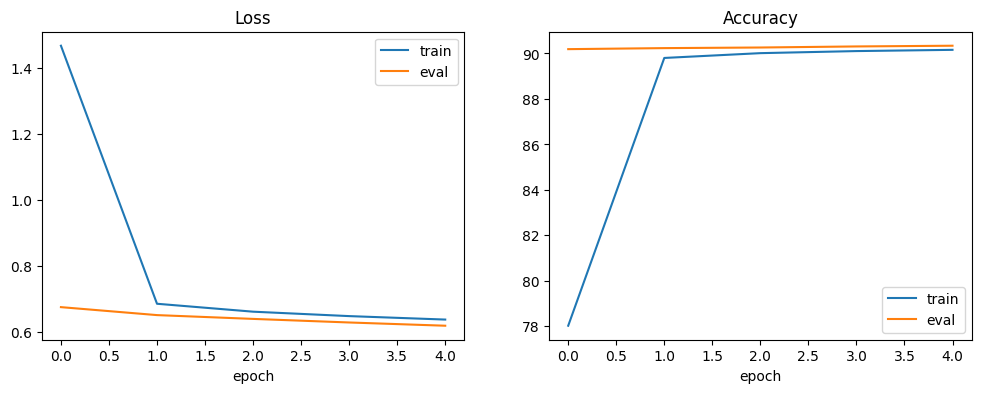

In [ ]:
#@title Plot learning curves

plot_learning_curves(history)

## Exemplo de uso

In [ ]:
class NextWord(nn.Module):
    def __init__(self, language_model, vocab, context_size):
        super(NextWord, self).__init__()
        self.model = language_model
        self.context_size = context_size
        self.vocab = vocab
        #self.inverse_vocab = {i: word for word, i in vocab.items()}
        self.sos_token = my_tokenizer.convert_tokens_to_ids("[SOS]")
        self.eos_token = my_tokenizer.convert_tokens_to_ids("[EOS]")

    def __call__(self, text, max_length, debug=False):
        #input = torch.tensor(self.str_to_tokens(text))
        #input = torch.cat([torch.tensor([SOS_TOKEN]), input]).to(device)
        input = self.vocab.encode(text, return_tensors='pt').to(device)
        input = input[:,:-1] # Delete eos token

        self.model.eval()
        with torch.no_grad():
            for step in range(len(input), max_length):
                # if the sequence context is growing too long we must crop it at block_size
                idx_cond = input if input.size(1) <= self.model.seq_len else input[:, -self.model.seq_len:]
                # get the predictions
                logits = self.model(idx_cond)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)

                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
                # append sampled index to the running sequence
                input = torch.cat((input, idx_next), dim=1) # (B, T+1)

                if debug:
                    print(f"Context: {idx_cond.tolist()} | Output: {idx_next.tolist()}")

                if idx_next in (self.sos_token, self.eos_token):
                    break
        #return self.tokens_to_str(input.squeeze(0).tolist())
        return self.vocab.decode(input.squeeze(0).tolist())

#next_word = NextWord(model, vocab, context_size)
next_word = NextWord(model, my_tokenizer, context_size)

print(f'\n===========> Test <===========')
text = "bom dia, tudo bem"
max_length= 25
next_word(text, max_length, debug=True)



===========> Test <===========
Context: [[2, 901, 325, 5, 351, 494]] | Output: [[325]]
Context: [[2, 901, 325, 5, 351, 494, 325]] | Output: [[494]]
Context: [[2, 901, 325, 5, 351, 494, 325, 494]] | Output: [[3444]]
Context: [[2, 901, 325, 5, 351, 494, 325, 494, 3444]] | Output: [[136]]
Context: [[901, 325, 5, 351, 494, 325, 494, 3444, 136]] | Output: [[103]]
Context: [[325, 5, 351, 494, 325, 494, 3444, 136, 103]] | Output: [[4342]]
Context: [[5, 351, 494, 325, 494, 3444, 136, 103, 4342]] | Output: [[128]]
Context: [[351, 494, 325, 494, 3444, 136, 103, 4342, 128]] | Output: [[32]]
Context: [[494, 325, 494, 3444, 136, 103, 4342, 128, 32]] | Output: [[1439]]
Context: [[325, 494, 3444, 136, 103, 4342, 128, 32, 1439]] | Output: [[5]]
Context: [[494, 3444, 136, 103, 4342, 128, 32, 1439, 5]] | Output: [[3159]]
Context: [[3444, 136, 103, 4342, 128, 32, 1439, 5, 3159]] | Output: [[5]]
Context: [[136, 103, 4342, 128, 32, 1439, 5, 3159, 5]] | Output: [[18]]
Context: [[103, 4342, 128, 32, 1439, 5

'[SOS] bom dia, tudo bem dia bem pouca com de universalou o segundo, tantas, a própria idéia que este e [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "que é uma boa literatura"
max_length= 150
next_word(text, max_length)

===========> Test <===========


'[SOS] que é uma boa literatura rapazes fosse uma pessoa mas faria a casa, e se consenti [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "mas o que é verdade"
max_length= 130
next_word(text, max_length)

===========> Test <===========


'[SOS] mas o que é verdade nos que mas mal. onde um sal ao dr e subiu que sei. é o seu melhor, a esta mica da vida era na jovem delica a vida ele e coisa, nem bastavado por eter, pensava é todos nunca é [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "o chapéu grande precisa de"
max_length= 120
next_word(text, max_length)

===========> Test <===========


'[SOS] o chapéu grande precisa de de chapéu olhosca com os seus tão pedi natura se clara [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "excelente dia para ficar em casa,"
max_length= 130
next_word(text, max_length)

===========> Test <===========


'[SOS] excelente dia para ficar em casa,, e não paulo. o corpo fez lhe o bachareleto a poesia, subse, que a que dissesse [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "o mistério nos olhos de capitu"
max_length= 130
next_word(text, max_length)

===========> Test <===========


'[SOS] o mistério nos olhos de capitu de de todo, não tenho depois a rebelmaisdar depoiss booidade à origem, e mais, disse quebir a miséria do [EOS]'

## Fine-tuning with LoRA

In [ ]:
#@title Lora class definition
class LoRALayer(nn.Module):
    """
    Create the matrices A and B for the LoRA model.
    Args:
        in_dim: input dimension
        out_dim: output dimension
        rank: rank of the LoRA model
        alpha: scaling factor for the LoRA model
    """
    def __init__(self, in_dim, out_dim, rank, alpha=1):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

class LinearWithLoRA(torch.nn.Module):
    """
    Combine the linear layer with the LoRA layer.
    Args:
        linear: linear layer
        rank: rank of the LoRA model
        alpha: scaling factor for the LoRA model
    """
    def __init__(self, linear, rank, alpha=1):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

class EmbeddingWithLoRA(nn.Module):
    def __init__(self, embed, rank, alpha=1):
        super().__init__()
        self.embedding = embed
        self.lora = LoRALayer(#embed.num_embeddings,
                              embed.embedding_dim,
                              embed.embedding_dim,
                              rank, alpha
        )
    def forward(self, x):
        embed = self.embedding(x)
        lora_output = self.lora(embed)
        return embed + lora_output

In [ ]:
# Inspect the structure of the model
print(model)

LanguageModel(
  (embedding): Embedding(5000, 64)
  (positional): Embedding(9, 64)
  (decoder_layers): ModuleList(
    (0-1): 2 x DecoderLayer(
      (self_attn): MultiHeadAttention(
        (Wv): Linear(in_features=64, out_features=64, bias=False)
        (Wk): Linear(in_features=64, out_features=64, bias=False)
        (Wq): Linear(in_features=64, out_features=64, bias=False)
        (Wo): Linear(in_features=64, out_features=64, bias=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=64, bias=True)
      (dropout1): Dropout(p=0.3, inplace=False)
      (dropout2): Dropout(p=0.3, inplace=False)
    )
  )
  (fc1): Linear(in_features=64, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=5000, bias=True

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")
    #if "lora_A" in name or "lora_B" in name:
    #    param.requires_grad = True
    #else:
    #    param.requires_grad = False

embedding.weight: True
positional.weight: True
decoder_layers.0.self_attn.Wv.weight: True
decoder_layers.0.self_attn.Wk.weight: True
decoder_layers.0.self_attn.Wq.weight: True
decoder_layers.0.self_attn.Wo.weight: True
decoder_layers.0.norm1.weight: True
decoder_layers.0.norm1.bias: True
decoder_layers.0.norm2.weight: True
decoder_layers.0.norm2.bias: True
decoder_layers.0.linear1.weight: True
decoder_layers.0.linear1.bias: True
decoder_layers.0.linear2.weight: True
decoder_layers.0.linear2.bias: True
decoder_layers.1.self_attn.Wv.weight: True
decoder_layers.1.self_attn.Wk.weight: True
decoder_layers.1.self_attn.Wq.weight: True
decoder_layers.1.self_attn.Wo.weight: True
decoder_layers.1.norm1.weight: True
decoder_layers.1.norm1.bias: True
decoder_layers.1.norm2.weight: True
decoder_layers.1.norm2.bias: True
decoder_layers.1.linear1.weight: True
decoder_layers.1.linear1.bias: True
decoder_layers.1.linear2.weight: True
decoder_layers.1.linear2.bias: True
fc1.weight: True
fc1.bias: True
f

In [ ]:
#@title Apply LoRA to the model
import copy

# Definition of lora hyperparameters
lora_rank = 16
lora_alpha = 2

model_lora = copy.deepcopy(model)

# Freeze all model parameters
for param in model_lora.parameters():
    param.requires_grad = False

model_lora.embedding = EmbeddingWithLoRA(model_lora.embedding, rank=lora_rank, alpha=lora_alpha)
model_lora.positional = EmbeddingWithLoRA(model_lora.positional, rank=lora_rank, alpha=lora_alpha)

# Apply lora to the model
for layer in model_lora.decoder_layers:
    layer.self_attn.Wk = LinearWithLoRA(layer.self_attn.Wk, rank=lora_rank, alpha=lora_alpha)
    layer.self_attn.Wq = LinearWithLoRA(layer.self_attn.Wq, rank=lora_rank, alpha=lora_alpha)
    layer.self_attn.Wv = LinearWithLoRA(layer.self_attn.Wv, rank=lora_rank, alpha=lora_alpha)
    layer.self_attn.Wo = LinearWithLoRA(layer.self_attn.Wo, rank=lora_rank, alpha=lora_alpha)
    layer.linear1 = LinearWithLoRA(layer.linear1, rank=lora_rank, alpha=lora_alpha)
    layer.linear2 = LinearWithLoRA(layer.linear2, rank=lora_rank, alpha=lora_alpha)

model_lora.fc1 = LinearWithLoRA(model_lora.fc1, rank=lora_rank, alpha=lora_alpha)
model_lora.fc2 = LinearWithLoRA(model_lora.fc2, rank=lora_rank, alpha=lora_alpha)

# Inspect the structure of the model
print(model_lora)

LanguageModel(
  (embedding): EmbeddingWithLoRA(
    (embedding): Embedding(5000, 64)
    (lora): LoRALayer()
  )
  (positional): EmbeddingWithLoRA(
    (embedding): Embedding(9, 64)
    (lora): LoRALayer()
  )
  (decoder_layers): ModuleList(
    (0-1): 2 x DecoderLayer(
      (self_attn): MultiHeadAttention(
        (Wv): LinearWithLoRA(
          (linear): Linear(in_features=64, out_features=64, bias=False)
          (lora): LoRALayer()
        )
        (Wk): LinearWithLoRA(
          (linear): Linear(in_features=64, out_features=64, bias=False)
          (lora): LoRALayer()
        )
        (Wq): LinearWithLoRA(
          (linear): Linear(in_features=64, out_features=64, bias=False)
          (lora): LoRALayer()
        )
        (Wo): LinearWithLoRA(
          (linear): Linear(in_features=64, out_features=64, bias=False)
          (lora): LoRALayer()
        )
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, el

In [ ]:
#@title Check the initital performance
loss, acc = valid_epoch(model, test_loader, criterion, device)
print(f'Test Init model ===> loss:{loss:.4f}, acc:{acc:.2f}%')
model_lora.to(device)
loss, acc = valid_epoch(model_lora, test_loader, criterion, device)
print(f'Test LoRA model ===> loss:{loss:.4f}, acc:{acc:.2f}%')

Test Init model ===> loss:0.6178, acc:90.34%
Test LoRA model ===> loss:0.6178, acc:90.34%


In [ ]:
#@title Check if weights are frozen
for name, param in model_lora.named_parameters():
    print(f"{name}: {param.requires_grad}")

embedding.embedding.weight: False
embedding.lora.A: True
embedding.lora.B: True
positional.embedding.weight: False
positional.lora.A: True
positional.lora.B: True
decoder_layers.0.self_attn.Wv.linear.weight: False
decoder_layers.0.self_attn.Wv.lora.A: True
decoder_layers.0.self_attn.Wv.lora.B: True
decoder_layers.0.self_attn.Wk.linear.weight: False
decoder_layers.0.self_attn.Wk.lora.A: True
decoder_layers.0.self_attn.Wk.lora.B: True
decoder_layers.0.self_attn.Wq.linear.weight: False
decoder_layers.0.self_attn.Wq.lora.A: True
decoder_layers.0.self_attn.Wq.lora.B: True
decoder_layers.0.self_attn.Wo.linear.weight: False
decoder_layers.0.self_attn.Wo.lora.A: True
decoder_layers.0.self_attn.Wo.lora.B: True
decoder_layers.0.norm1.weight: False
decoder_layers.0.norm1.bias: False
decoder_layers.0.norm2.weight: False
decoder_layers.0.norm2.bias: False
decoder_layers.0.linear1.linear.weight: False
decoder_layers.0.linear1.linear.bias: False
decoder_layers.0.linear1.lora.A: True
decoder_layers.0.

### Run LoRA

In [ ]:
epochs = 10
lr = 1e-4; """TODO, experimente!"""
#criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN); """TODO CrossEntropy"""
criterion = nn.CrossEntropyLoss(ignore_index=my_tokenizer.convert_tokens_to_ids("[PAD]")); """TODO CrossEntropy"""

#optimizer = torch.optim.Adam(model.parameters(), lr=lr); """TODO: AdamW ou outro, experimente!"""
optimizer = torch.optim.AdamW(model_lora.parameters(), lr=lr)

history = train(model_lora, valid_loader, test_loader, criterion, optimizer, epochs, device)

[Initial] Test loss:0.6178, Test acc:90.34%, Perplexity:1.85
Epoch [1/10], Train loss:0.6341, Train acc:90.18%, Test loss:0.6170, Test acc: 90.35%, Perplexity:1.85, Elapsed Time: 49.81 sec
Epoch [2/10], Train loss:0.6321, Train acc:90.19%, Test loss:0.6161, Test acc: 90.35%, Perplexity:1.85, Elapsed Time: 49.58 sec
Epoch [3/10], Train loss:0.6308, Train acc:90.19%, Test loss:0.6156, Test acc: 90.35%, Perplexity:1.85, Elapsed Time: 50.71 sec
Epoch [4/10], Train loss:0.6301, Train acc:90.19%, Test loss:0.6147, Test acc: 90.36%, Perplexity:1.85, Elapsed Time: 49.51 sec
Epoch [5/10], Train loss:0.6291, Train acc:90.19%, Test loss:0.6142, Test acc: 90.35%, Perplexity:1.85, Elapsed Time: 49.65 sec
Epoch [6/10], Train loss:0.6284, Train acc:90.20%, Test loss:0.6138, Test acc: 90.36%, Perplexity:1.85, Elapsed Time: 51.19 sec
Epoch [7/10], Train loss:0.6274, Train acc:90.19%, Test loss:0.6136, Test acc: 90.36%, Perplexity:1.85, Elapsed Time: 49.41 sec
Epoch [8/10], Train loss:0.6269, Train acc:

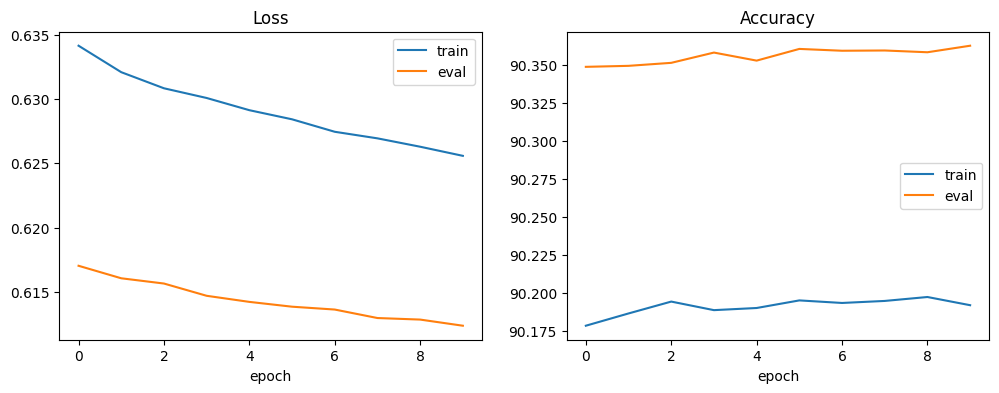

In [ ]:
# Plot learning curves
plot_learning_curves(history)

In [ ]:
class NextWord(nn.Module):
    def __init__(self, language_model, vocab, context_size):
        super(NextWord, self).__init__()
        self.model = language_model
        self.context_size = context_size
        self.vocab = vocab
        #self.inverse_vocab = {i: word for word, i in vocab.items()}
        self.sos_token = my_tokenizer.convert_tokens_to_ids("[SOS]")
        self.eos_token = my_tokenizer.convert_tokens_to_ids("[EOS]")

    def __call__(self, text, max_length, debug=False):
        #input = torch.tensor(self.str_to_tokens(text))
        #input = torch.cat([torch.tensor([SOS_TOKEN]), input]).to(device)
        input = self.vocab.encode(text, return_tensors='pt').to(device)
        input = input[:,:-1] # Delete eos token

        self.model.eval()
        with torch.no_grad():
            for step in range(len(input), max_length):
                # if the sequence context is growing too long we must crop it at block_size
                idx_cond = input if input.size(1) <= self.model.seq_len else input[:, -self.model.seq_len:]
                # get the predictions
                logits = self.model(idx_cond)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)

                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
                # append sampled index to the running sequence
                input = torch.cat((input, idx_next), dim=1) # (B, T+1)

                if debug:
                    print(f"Context: {idx_cond.tolist()} | Output: {idx_next.tolist()}")

                if idx_next in (self.sos_token, self.eos_token):
                    break
        #return self.tokens_to_str(input.squeeze(0).tolist())
        return self.vocab.decode(input.squeeze(0).tolist())

#next_word = NextWord(model, vocab, context_size)
next_word = NextWord(model_lora, my_tokenizer, context_size)

print(f'\n===========> Test <===========')
text = "bom dia, tudo bem"
max_length= 25
next_word(text, max_length, debug=True)


===========> Test <===========
Context: [[2, 901, 325, 5, 351, 494]] | Output: [[351]]
Context: [[2, 901, 325, 5, 351, 494, 351]] | Output: [[351]]
Context: [[2, 901, 325, 5, 351, 494, 351, 351]] | Output: [[351]]
Context: [[2, 901, 325, 5, 351, 494, 351, 351, 351]] | Output: [[267]]
Context: [[901, 325, 5, 351, 494, 351, 351, 351, 267]] | Output: [[160]]
Context: [[325, 5, 351, 494, 351, 351, 351, 267, 160]] | Output: [[1344]]
Context: [[5, 351, 494, 351, 351, 351, 267, 160, 1344]] | Output: [[369]]
Context: [[351, 494, 351, 351, 351, 267, 160, 1344, 369]] | Output: [[32]]
Context: [[494, 351, 351, 351, 267, 160, 1344, 369, 32]] | Output: [[1888]]
Context: [[351, 351, 351, 267, 160, 1344, 369, 32, 1888]] | Output: [[5]]
Context: [[351, 351, 267, 160, 1344, 369, 32, 1888, 5]] | Output: [[22]]
Context: [[351, 267, 160, 1344, 369, 32, 1888, 5, 22]] | Output: [[126]]
Context: [[267, 160, 1344, 369, 32, 1888, 5, 22, 126]] | Output: [[139]]
Context: [[160, 1344, 369, 32, 1888, 5, 22, 126, 

'[SOS] bom dia, tudo bem tudo tudo tudo ser os grandes olhos o interesse, e um do bra em clepe cargo e lficavia das'

In [ ]:
print(f'===========> Test <===========')
text = "que é uma boa literatura"
max_length= 150
next_word(text, max_length)

===========> Test <===========


'[SOS] que é uma boa literatura literatura rapazes que as ru o tempo de fechou o seminário, adojavajar e no teatro os ifico pido em dizer dim. assim é porque é ficar, a jardimem, nessa de paris [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "mas o que é verdade"
max_length= 130
next_word(text, max_length)

===========> Test <===========


'[SOS] mas o que é verdade verdade nos mas ali a afeiçãoos de para mim e [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "o chapéu grande precisa de"
max_length= 120
next_word(text, max_length)

===========> Test <===========


'[SOS] o chapéu grande precisa de de de de um dia para que nomes elo desse ganhcus cases que esta sociedadevemadonhosse mais vulgar, ele com [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "excelente dia para ficar em casa,"
max_length= 130
next_word(text, max_length)

===========> Test <===========


'[SOS] excelente dia para ficar em casa,, e havia de boa coisa, antes olhos que alguns sair mais dá enxuado, pegoujars nem cristiai a sua camp lhe impzinha a reuna, mas [EOS]'